In [106]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [107]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as patches

In [108]:
reduced_dataset_folder = '/home/usuario/repos/Object_Localization/challenge_dataset_v3'
train_folder = reduced_dataset_folder + '/images/train'
val_folder = reduced_dataset_folder + '/images/val'
annotations_dict_train = np.load(reduced_dataset_folder+'/annotations_train.npy').flat[0]
annotations_dict_val = np.load(reduced_dataset_folder+'/annotations_val.npy').flat[0]
classes = list(annotations_dict_train.keys())
print(classes)

['n02165456', 'n02226429', 'n01644373', 'n02279972', 'n01632458', 'n02256656', 'n01774384', 'n01770393']


In [109]:
classes_names = {
    'n02165456': 'Vaquita de san antonio',
    'n02226429': 'grillo',
    'n01644373': 'sapo',
    'n02279972': 'mariposa',
    'n01632458': 'salamandra',
    'n02256656': 'chicharra',
    'n01774384': 'viuda negra',
    'n01770393': 'escorpion'
}

In [110]:
from yolo_helper import PASCAL_VOC_bbox_2_yolo, yolo_bbox_2_PASCAL_VOC, GeneratorMultipleOutputs

In [111]:
def plot_yolo_images(images, annot, count=10):
    #for index in range(len(images)):
    for index in range(count):
        f, ax = plt.subplots(1,1, figsize=(20,10))
        ax.imshow(images[index])
        annotation_ = annot[index]
        GRID_H = annotation_.shape[1]
        GRID_W = annotation_.shape[0]
        im_height = images[0].shape[0]
        im_width = images[0].shape[1]

        grid_h, grid_w = np.where(annotation_[:,:,0, 0] == 1)
        in_grid_H = grid_h[0]
        in_grid_W = grid_w[0]
        yolo_bbox = annotation_[in_grid_H,in_grid_W,0][1+len(classes):]
        bbox = yolo_bbox_2_PASCAL_VOC((in_grid_H, in_grid_W), 
                                      yolo_bbox, 
                                      im_height, im_width, GRID_H, GRID_W)
        print(annotation_[in_grid_H,in_grid_W])
        rect_gt = patches.Rectangle([bbox[0], bbox[1]],
                                    bbox[2]-bbox[0],
                                    bbox[3]-bbox[1],
                                    linewidth=2, edgecolor='b',facecolor='none')
        ax.add_patch(rect_gt)
        ax.scatter(bbox[0] + (bbox[2]-bbox[0])/2, bbox[1] + (bbox[3]-bbox[1])/2)
        GRID_H = annotation_.shape[1]
        GRID_W = annotation_.shape[0]
        step_y = im_height/GRID_H
        step_x = im_width/GRID_W
        for i in range(GRID_W):
            plt.vlines(i*step_x, 0, im_height, lw=0.5)
        for i in range(GRID_H): 
            plt.hlines(i*step_y, 0, im_width, lw=0.5)
        plt.axis('off')
        plt.show()
        print('GRID_X:', in_grid_W)
        print('GRID_Y:', in_grid_H)
        print('CENTER_X:', yolo_bbox[0])
        print('CENTER_Y:', yolo_bbox[1])
        print('WIDTH:', yolo_bbox[2])
        print('HEIGHT:', yolo_bbox[3])

In [127]:
# Solo correr esta celda si queremos importar la arquitectura de YOLOv2
from yolo_helper import get_YOLO_V2_NN
n_classes = len(classes)
GRID_H,  GRID_W  = 10 , 10
IMAGE_H, IMAGE_W = GRID_H*32, GRID_W*32
target_size = (IMAGE_H, IMAGE_W)
print(IMAGE_H, IMAGE_W)
BOX = 1
CLASS = n_classes
model = get_YOLO_V2_NN(IMAGE_H, IMAGE_W, BOX, CLASS, GAP=False)
# Le pongo el mismo nombre que en el otro modelo para que asigne la loss bien
# model.layers[-1].name='concatenated_outputs'
model.layers[-1].output

320 320


<tf.Tensor 'reshape_9/Reshape:0' shape=(?, 10, 10, 1, 13) dtype=float32>

In [128]:
#model.load_weights('yolo_weights_64_64_50_epochs.hdf5')
#model.load_weights('yolo_weights_128_128_80_epochs.hdf5')
#model.load_weights('yolo_weights_256_256_100_epochs.hdf5')
#model.load_weights('yolo_weights_flip_both_3.hdf5')


In [129]:
#model.save_weights('yolo_weights_flip_both_3.hdf5')

In [130]:
train_generator = GeneratorMultipleOutputs(annotations_dict_train, 
                            train_folder, 32, classes = classes,
                            target_size=(IMAGE_H,IMAGE_W),
                            GRID_H = GRID_H,
                            GRID_W = GRID_W, flip_horizontal = True, flip_vertical = False
                                           
                           )
images, annot = next(train_generator)
#plot_yolo_images(images, annot, count=10)

Found 2400 images belonging to 8 classes.


In [131]:
val_generator = GeneratorMultipleOutputs(annotations_dict_val, 
                            val_folder, 32, classes = classes,
                            target_size=(IMAGE_H,IMAGE_W),
                            GRID_H = GRID_H,
                            GRID_W = GRID_W,
                            flip_horizontal = True, 
                            flip_vertical=False
                           )
images, annot = next(val_generator)
#plot_yolo_images(images, annot, count=1)

Found 480 images belonging to 8 classes.


In [132]:
from yolo_helper import negative_bin_cross_entropy_loss, yolo_loss, classes_acc, confidence_acc_with_sigmoid, bounding_box_mse, iou_metric, positive_bin_cross_entropy_loss, categorical_cross_entropy_loss

In [133]:
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam, rmsprop, SGD
filename = 'runtime'
checkpoint = ModelCheckpoint(filepath = filename+'_best.hdf5', 
                             monitor='val_classes_acc', save_best_only=True)
model.compile(loss=yolo_loss,
              optimizer=Adam(lr=0.001),
              metrics=[negative_bin_cross_entropy_loss, classes_acc, confidence_acc_with_sigmoid, bounding_box_mse, iou_metric, positive_bin_cross_entropy_loss, categorical_cross_entropy_loss]
             )

In [134]:
from object_detection_helper import PlotLosses

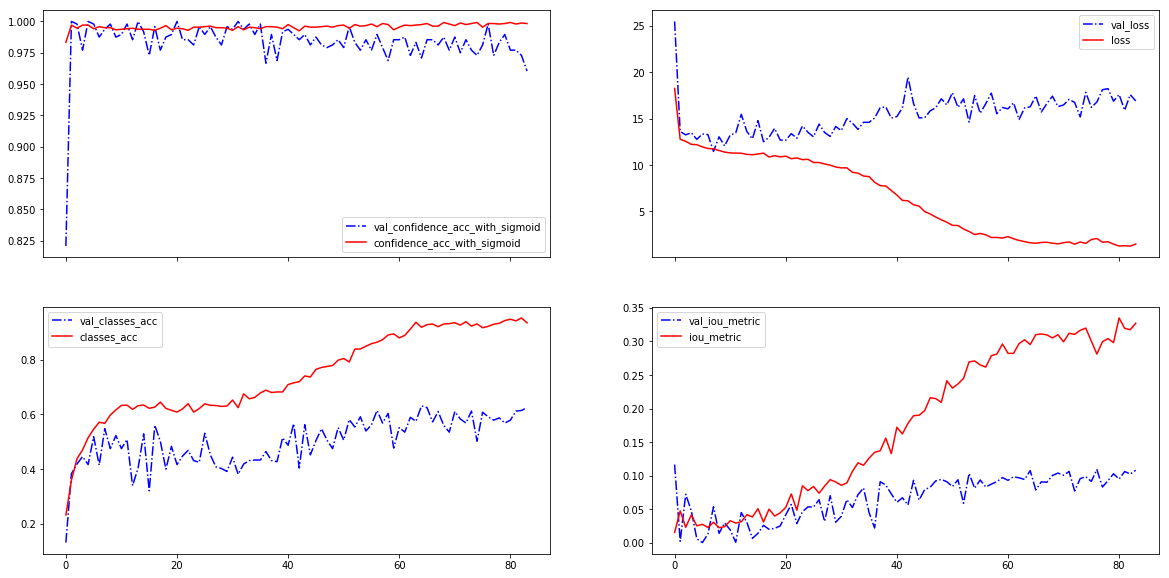

Epoch 85/2000
 6/75 [=>............................] - ETA: 20s - loss: 1.4017 - negative_bin_cross_entropy_loss: 0.5078 - classes_acc: 0.9688 - confidence_acc_with_sigmoid: 1.0000 - bounding_box_mse: 1.2144 - iou_metric: 0.3206 - positive_bin_cross_entropy_loss: 0.0147 - categorical_cross_entropy_loss: 0.1218

KeyboardInterrupt: 

In [135]:
plot_losses = PlotLosses(1)
model.fit_generator(
        train_generator,
        epochs=2000,
        validation_data=val_generator,callbacks = [plot_losses]
        )

In [16]:
#model.save_weights('yolo_weights_128_128_80_epochs.hdf5')
model.save_weights('yolo_weights_flip_both_2.hdf5')

In [ ]:
model.evaluate_generator(train_generator)

In [ ]:
model.evaluate_generator(val_generator)

In [ ]:
predictions = model.predict_generator(val_generator)

In [ ]:
classes_ground_truth = val_generator.generator.classes[ val_generator.generator.index_array  ]

In [ ]:
for pred in predictions:
    print(pred.reshape(100, 13).shape)

In [1]:
batch = next(val_generator)
images = batch[0]
annot = batch[1]
predictions = model.predict_on_batch(images)

NameError: name 'val_generator' is not defined

In [ ]:
import math

def sigmoid(x):
    return 1 / (1 + math.exp(-x))

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
#print(confusion_matrix(validation_generator.classes, y_pred))

In [ ]:
generator = train_generator
for index in range(len(images)):
    f, ax = plt.subplots(1,1, figsize=(20,10))
    ax.imshow(images[index])
    annotation_ = annot[index]
    GRID_H = annotation_.shape[1]
    GRID_W = annotation_.shape[0]
    im_height = images[0].shape[0]
    im_width = images[0].shape[1]

    grid_h, grid_w = np.where(annotation_[:,:,0, 0] == 1)
    in_grid_H = grid_h[0]
    in_grid_W = grid_w[0]
    
    annotation_simple = annotation_[in_grid_H,in_grid_W][0]
    yolo_bbox = annotation_simple[1+len(classes):]
    
    # En este caso busco todos los que son mayores a 0.5
    #pred_idx = np.where(predictions[index][:,:,0, 0] > 0.5)
    
    # Aca hago trampa ya que supongo que hay solo uno
    pred_idx = np.where(predictions[index][:,:,0, 0]==predictions[index][:,:,0, 0].max())
    prediction = predictions[index][pred_idx]
    prediction_simple = prediction[0][0]
    predicted_yolo_box = prediction_simple[1+len(classes):]
    
    
    print('class:',  classes_names[generator.idx_2_class_id[np.argmax(annotation_simple[1:1+n_classes])]], ', Pred clas:', classes_names[generator.idx_2_class_id[np.argmax(prediction_simple[1:1+n_classes])]])
    
    bbox = yolo_bbox_2_PASCAL_VOC((in_grid_H, in_grid_W), 
                                  yolo_bbox, 
                                  im_height, im_width, GRID_H, GRID_W)
    
    #print(prediction_simple[0], pred_idx, (pred_idx[0][0], pred_idx[1][0]))
    predicted_box = yolo_bbox_2_PASCAL_VOC((pred_idx[0][0], pred_idx[1][0]), 
                                  predicted_yolo_box, 
                                  im_height, im_width, GRID_H, GRID_W)
    
    rect_gt = patches.Rectangle([bbox[0], bbox[1]],
                                bbox[2]-bbox[0],
                                bbox[3]-bbox[1],
                                linewidth=2, edgecolor='y',facecolor='none')
    
    ax.add_patch(rect_gt)
    
    pred_rect = patches.Rectangle([predicted_box[0], predicted_box[1]],
                                predicted_box[2]-predicted_box[0],
                                predicted_box[3]-predicted_box[1],
                                linewidth=2, edgecolor='b',facecolor='none')
    
    ax.add_patch(pred_rect)
    
    ax.scatter(bbox[0] + (bbox[2]-bbox[0])/2, bbox[1] + (bbox[3]-bbox[1])/2, c='y')
    ax.scatter(predicted_box[0] + (predicted_box[2]-predicted_box[0])/2, predicted_box[1] + (predicted_box[3]-predicted_box[1])/2, c='b')
    
    GRID_H = annotation_.shape[1]
    GRID_W = annotation_.shape[0]
    step_y = im_height/GRID_H
    step_x = im_width/GRID_W
    for i in range(GRID_W):
        plt.vlines(i*step_x, 0, im_height, lw=0.5)
    for i in range(GRID_H): 
        plt.hlines(i*step_y, 0, im_width, lw=0.5)
    plt.axis('off')
    
    for i in range(GRID_W):
        for j in range(GRID_H):
            plt.text(i*step_x+step_x/2, j*step_y +step_y/2, 
                     '{0:.2f}'.format(sigmoid(predictions[index][j,i,0, 0])),
                     verticalalignment='center', horizontalalignment='center')
    print('GRID_X:', in_grid_W, pred_idx[1][0])
    print('Object Prob:', sigmoid(prediction_simple[0]))
    print('Class Prob:', max(softmax(prediction_simple[1: 1+n_classes])))
    print('GRID_Y:', in_grid_H, pred_idx[0][0])
    print('CENTER_X:', yolo_bbox[0])
    print('CENTER_Y:', yolo_bbox[1])
    print('WIDTH:', yolo_bbox[2])
    print('HEIGHT:', yolo_bbox[3])
    plt.show()

In [ ]:
import tensorflow as tf
out = classes_acc(tf.constant(annot), tf.constant(predictions))

sess = tf.Session()
with sess.as_default():
    print(out.eval())

In [ ]:
(32, 10, 10, 1)

In [ ]:
indexes = np.where(annot[:,:,:,:,0] == 1)

In [ ]:
indexes

In [ ]:
annot.shape, predictions.shape

In [ ]:
predictions[indexes].shape

In [ ]:
np.where(annot[:,:,])